In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import numpy as np

import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

In [41]:
tickers = ['ACHR', 'LIQT', 'USDP', 'FSI', 'GEVO', 'QQQ']
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*5)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

i = 1
for ticker in tickers:        
    if i == 1:
        full_df = yf.download(
            ticker, 
            start=start_date, 
            end=end_date, 
            progress=False
        )
        full_df = full_df[['Adj Close']].reset_index()
        full_df.rename(columns={'Adj Close': ticker}, inplace=True)
        full_df.set_index('Date', inplace=True)
        i+=1
    else:
        temp = yf.download(
            ticker, 
            start=start_date, 
            end=end_date, 
            progress=False
        )
        temp = temp[['Adj Close']].reset_index()
        temp.rename(columns={'Adj Close': ticker}, inplace=True)
        temp.set_index('Date', inplace=True)

        full_df = pd.concat([full_df, temp], axis=1)
        i+=1

full_df.dropna(inplace=True)
full_df.head()

,ACHR,LIQT,USDP,FSI,GEVO,QQQ
Date,,,,,,
2020-12-18,9.97,8.54,3.333923,2.470,2.39,307.634827
2020-12-21,10.07,8.35,3.270333,2.460,2.86,307.059326
2020-12-22,10.02,8.25,3.270333,2.440,2.87,307.894226
2020-12-23,10.06,8.14,3.279417,2.460,2.91,306.343658
2020-12-24,10.03,8.29,3.311212,2.485,3.70,307.695404


[0.0397705  0.03343636 0.35790858 0.12158728 0.22734935 0.21994794]


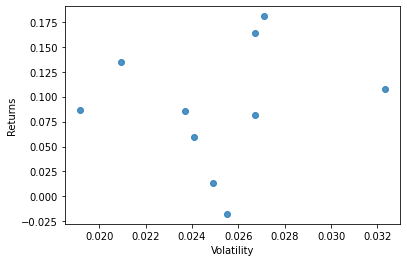

In [42]:
# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for d in sorted(covariances.keys()):
    cov = covariances[d]
    for portfolio in range(10):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[d])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(d, []).append(returns)
        portfolio_volatility.setdefault(d, []).append(volatility)
        portfolio_weights.setdefault(d, []).append(weights)
        
print(portfolio_weights[d][0])

# Get latest date of available data
d = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(
    x=portfolio_volatility[d],
    y=portfolio_returns[d],
    alpha=0.8
)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

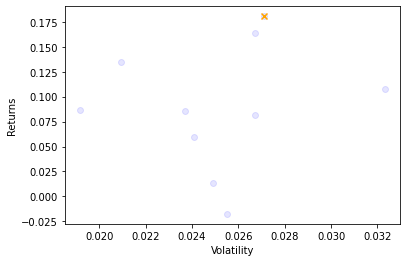

In [43]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

targets, features = [], []

# Create features from price history and targets as ideal portfolio
for d, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[d]
    targets.append(portfolio_weights[d][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)

# Get most recent (current) returns and volatility
d = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[d]
cur_volatility = portfolio_volatility[d]

# Plot efficient frontier with sharpe as point
plt.scatter(
    x=cur_volatility, 
    y=cur_returns, 
    alpha=0.1, 
    color='blue'
)
best_idx = max_sharpe_idxs[d]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(
    x=cur_volatility[best_idx], 
    y=cur_returns[best_idx], 
    marker='x', 
    color='orange'
)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

0.8497651302500658
-139.33952298418268


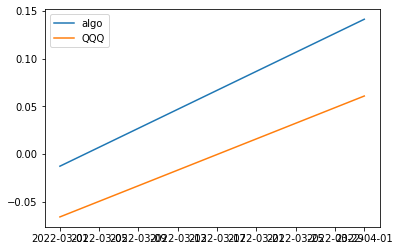

In [46]:
from sklearn.ensemble import RandomForestRegressor

# Make train and test features
train_size = int(0.9 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['QQQ'].iloc[train_size:], label='QQQ')
plt.legend()
plt.show()

algo returns: 0.12698601512892196
FSI returns: 0.15789472216567718


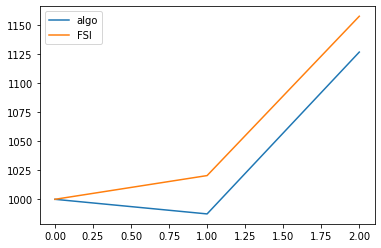

In [49]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, fsi_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['FSI'].iloc[train_size:]:
    cash *= 1 + r
    fsi_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('FSI returns:', (fsi_cash[-1] - fsi_cash[0]) / fsi_cash[0])

# Plot the algo_cash and fsi_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(fsi_cash, label='FSI')
plt.legend()  # show the legend
plt.show()